In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(r"./Images", image_size = (224,224), batch_size = 40, label_mode = "int", shuffle = True)

Found 200 files belonging to 2 classes.


In [3]:
class_names = dataset.class_names
class_names

['alligator', 'shark']

In [4]:
len(dataset)

5

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(40, 224, 224, 3)
[1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0
 0 1 0]


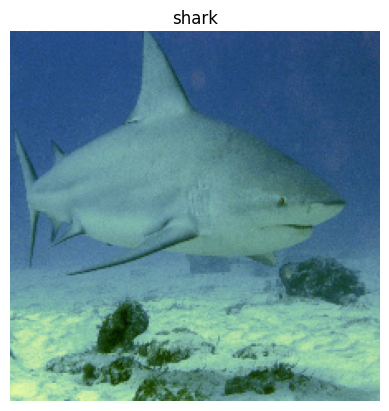

In [6]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[1].numpy().astype("uint8"))
    plt.title(class_names[label_batch[1]])
    plt.axis("off")

In [7]:
train_ds = dataset.take(4)
test_ds = dataset.skip(4)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(224,224),
    layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [8]:
model_VGG_Block_1 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(64, (3,3), activation = "relu", padding = "same", input_shape = (40,224,224,3)),
    layers.Conv2D(64, (3,3), activation = "relu", padding = "same"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(64, activation= "relu"),
    layers.Dense(2, activation = "softmax")
])

model_VGG_Block_1.build(input_shape= (40,224,224,3))

c:\Users\Vansh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model_VGG_Block_3 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(64, (3,3), activation = "relu", padding = "same", input_shape = (40,224,224,3)),
    layers.Conv2D(64, (3,3), activation = "relu", padding = "same"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(128, (3,3), activation = "relu", padding = "same", input_shape = (40,224,224,3)),
    layers.Conv2D(128, (3,3), activation = "relu", padding = "same"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(256, (3,3), activation = "relu", padding = "same", input_shape = (40,224,224,3)),
    layers.Conv2D(256, (3,3), activation = "relu", padding = "same"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(64, activation= "relu"),
    layers.Dense(2, activation = "softmax")
])

model_VGG_Block_3.build(input_shape=(40,224,224,3))

In [10]:
model_VGG_Block_3_data_augmentation = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64, (3,3), activation = "relu", padding = "same", input_shape = (40,224,224,3)),
    layers.Conv2D(64, (3,3), activation = "relu", padding = "same"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(128, (3,3), activation = "relu", padding = "same", input_shape = (40,224,224,3)),
    layers.Conv2D(128, (3,3), activation = "relu", padding = "same"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(256, (3,3), activation = "relu", padding = "same", input_shape = (40,224,224,3)),
    layers.Conv2D(256, (3,3), activation = "relu", padding = "same"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(64, activation= "relu"),
    layers.Dense(2, activation = "softmax")
])

model_VGG_Block_3_data_augmentation.build(input_shape = (40,224,224,3))

In [11]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16.trainable = True  

model_transfer_learning_all_layers = tf.keras.Sequential([
    vgg16,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax') 
])

In [12]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16.trainable = False  

model_transfer_learning_mlp = tf.keras.Sequential([
    vgg16,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')  
])


In [13]:
model_MLP = models.Sequential([
    resize_and_rescale,  
    layers.Flatten(input_shape=(224, 224, 3)),  
    layers.Dense(4096, activation='relu'),  
    layers.Dropout(0.5),  
    layers.Dense(2048, activation='relu'), 
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'), 
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  
])

c:\Users\Vansh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
import time
import pandas as pd
from tensorflow.keras.callbacks import TensorBoard

pd.set_option('display.width', 1000)

results_table = pd.DataFrame(columns=["Model", "Training Time (s)", "Training Loss", "Training Accuracy", "Testing Accuracy", "Parameters"])

def eval_model(model, train_data, test_data, model_name, epoch):

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=r"D:\logs", histogram_freq=1)

    model.compile(optimizer = "adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), metrics= ["accuracy"])

    start_time = time.time()
    history = model.fit(train_data, epochs = epoch, verbose =1, callbacks = tensorboard_callback)
    training_time = time.time() - start_time

    training_loss = history.history['loss'][-1]
    training_accuracy = history.history['accuracy'][-1]

    _, test_accuracy = model.evaluate(test_data)

    param_count = model.count_params()

    results_table.loc[len(results_table)] = [
        model_name,
        f"{training_time:.2f}",  
        f"{training_loss:.4f}",  
        f"{training_accuracy:.2f}", 
        f"{test_accuracy:.2f}",     
        f"{param_count:,}"  
    ]


eval_model(model_VGG_Block_1, train_ds, test_ds, "VGG_Block_1", 3)
print()
eval_model(model_VGG_Block_3, train_ds, test_ds, "VGG_Block_3", 3)
print()
eval_model(model_VGG_Block_3_data_augmentation, train_ds, test_ds, "VGG_Block_3_data_augmentation", 3)
print()
eval_model(model_transfer_learning_all_layers, train_ds, test_ds, "transfer_learning_all_layer", 3)
print()
eval_model(model_transfer_learning_mlp, train_ds, test_ds, "transfer_learning_mlp", 3)
print()
eval_model(model_MLP,train_ds,test_ds,"Model_MLP",3)

print(results_table)


Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4057 - loss: 24.0211

In [15]:
from tensorflow.keras.preprocessing import image
import numpy as np

generated_images_dir = r"./GeneratedImages"
image_files = ["A_Easy.jpg", "A_Hard.jpg", "B_Easy.jpg", "B_Hard.jpg"]

def evaluate_generated_images(models, class_names):
    results = []
    for model_name, model in models.items():
        for img_file in image_files:
            img_path = f"{generated_images_dir}/{img_file}"
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = img_array / 255.0  

            prediction = model.predict(img_array)
            predicted_class = class_names[np.argmax(prediction)]
            confidence = np.max(prediction)

            results.append({
                "Model": model_name,
                "Image": img_file,
                "Predicted Class": predicted_class,
                "Confidence": f"{confidence:.2f}"
            })
    return results

models = {
    "VGG_Block_1": model_VGG_Block_1,
    "VGG_Block_3": model_VGG_Block_3,
    "VGG_Block_3_Data_Augmentation": model_VGG_Block_3_data_augmentation,
    "Transfer_Learning_All_Layers": model_transfer_learning_all_layers,
    "Transfer_Learning_MLP": model_transfer_learning_mlp,
    "Model_MLP": model_MLP
}

generated_image_results = evaluate_generated_images(models, class_names)

import pandas as pd
results_df = pd.DataFrame(generated_image_results)
results_df.to_csv("generated_image_results.csv", index=False)
print(results_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
                            Model       Image Predicted Class Confidence
0     

In [16]:
import os
import tensorflow as tf
from tensorflow.summary import create_file_writer

log_dir = r"./logs/generated_images"
os.makedirs(log_dir, exist_ok=True)

def log_generated_image_predictions(models, class_names):
    with create_file_writer(log_dir).as_default():
        for model_name, model in models.items():
            for img_file in image_files:
                img_path = f"{generated_images_dir}/{img_file}"
                img = image.load_img(img_path, target_size=(224, 224))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = img_array / 255.0  # Rescale

                prediction = model.predict(img_array)
                predicted_class = class_names[np.argmax(prediction)]
                confidence = np.max(prediction)

                tf.summary.image(f"{model_name} - {img_file}", img_array, step=0)
                tf.summary.text(f"{model_name} - Prediction", f"{predicted_class} ({confidence:.2f})", step=0)

log_generated_image_predictions(models, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [ ]:
generated_image_results_df = pd.DataFrame(generated_image_results)
generated_image_results_df.to_csv("Generated_Image_Predictions.csv", index=False)
print("Generated image predictions saved as 'Generated_Image_Predictions.csv'.")


Generated image predictions saved as 'Generated_Image_Predictions.csv'.


In [ ]:
# tensorboard --logdir="C:\Users\Vansh\Desktop\Coding\ML\Final Assignment 4"


# Insights and Observations

## Expected Results
All models predicted correctly, though confidence varied. Transfer Learning showed higher confidence, likely due to pre-trained features.

## Data Augmentation
Data augmentation improved generalization slightly, as `VGG_Block_3_Data_Augmentation` matched the performance of other models.

## Fine-Tuning Epochs
Three epochs were sufficient for correct predictions. However, increasing the number of epochs may further boost confidence, particularly for VGG models.

## Confusing Images
No confusion was observed since all predictions were correct. However, confidence varied significantly across models, highlighting differences in model certainty.
